<a href="https://colab.research.google.com/github/ZohebAbai/Tiny-ImageNet-Challenge/blob/master/TinyImageNet_Network_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing libraries and Downloading Dataset

In [1]:
## Download the dataset and unzip it 
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

--2021-12-13 02:25:11--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  5.49MB/s    in 34s     

2021-12-13 02:25:46 (6.90 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [ ]:
#Unzip data
!unzip 'tiny-imagenet-200.zip'
!ls

In [1]:
# Importing important libraries
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, concatenate, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, SeparableConv2D
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import imgaug as ia
from imgaug import augmenters as iaa

import tensorflow_addons as tfa

# random seed
np.random.seed(seed=101)
ia.seed(101)

# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf

# Don't pre-allocate memory; allocate as-needed
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True

# Create a session with the above options specified.
#k.tensorflow_backend.set_session(tf.Session(config=config))

# input image dimensions
img_height = 64
img_width = 64
channels = 3

# Hyperparameters
batch_size = 128
num_classes = 200
epochs = 24
num_train = 100000
num_validation = 10000

In [2]:
#Load validation data
import numpy as np
import pandas as pd
val_data = pd.read_csv('./tiny-imagenet-200/val/val_annotations.txt', sep='\t', header=None, 
                       names=['File', 'Class', 'X', 'Y', 'H', 'W'])
val_data.drop(['X', 'Y', 'H', 'W'], axis=1, inplace=True)
val_data.head(3)

,File,Class
0,val_0.JPEG,n03444034
1,val_1.JPEG,n04067472
2,val_2.JPEG,n04070727


# Image Augmentation

In [3]:
# Defining Customized Imagedatagenerator using imgaug library
def CustomImageDataGen(input_img):
  # Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
  # e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second
  # image.
  sometimes = lambda aug: iaa.Sometimes(0.5, aug)
  
  seq = iaa.Sequential([
      iaa.Fliplr(0.5), # horizontal flips
      iaa.Flipud(0.2), # vertical flips
      
      # Small gaussian blur with random sigma between 0 and 0.5.
      # But we only blur about 50% of all images.
      sometimes(iaa.GaussianBlur(sigma=(0, 2.0))),
      
      # crop images by -10% to 20% of their height/width
      sometimes(iaa.CropAndPad(
          percent=(-0.1, 0.2),
          pad_mode=ia.ALL,
          pad_cval=(0, 255)
        )),
      
      # Apply affine transformations to some of the images
      # - scale to 80-120% of image height/width (each axis independently)
      # - translate by -20 to +20 relative to height/width (per axis)
      # - rotate by -45 to +45 degrees
      # - shear by -16 to +16 degrees
      # - order: use nearest neighbour or bilinear interpolation (fast)
      # - mode: use any available mode to fill newly created pixels
      #         see API or scikit-image for which modes are available
      # - cval: if the mode is constant, then use a random brightness
      #         for the newly created pixels (e.g. sometimes black,
      #         sometimes white)
      sometimes(iaa.Affine(
          scale={"x": (0.8, 1.5), "y": (0.8, 1.5)},
          translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
          rotate=(-45, 45),
          shear=(-16, 16),
          order=[0, 1],
          cval=(0, 255),
          mode=ia.ALL
      )),
      
      #drop 2-5% percent of the original size, leading to large dropped
      # rectangles.
      sometimes(iaa.CoarseDropout(
                        (0.03, 0.15), size_percent=(0.02, 0.05),
                        per_channel=0.2
                    )),
                
      # Make some images brighter and some darker.
      # In 20% of all cases, we sample the multiplier once per channel,
      # which can end up changing the color of the images.
      sometimes(iaa.Multiply((0.8, 1.2), per_channel=0.2)),
      
      #Improve or worsen the contrast of images.
      #Comment it out after third model run (extreme saturation)
      sometimes(iaa.ContrastNormalization((0.75, 1.5), per_channel=0.5)), 
     ],
     # do all of the above augmentations in random order
     random_order = True) # apply augmenters in random order
  
  output_img = seq.augment_image(input_img)
  return output_img

train_datagen = ImageDataGenerator(rescale=1/255., preprocessing_function = CustomImageDataGen)
valid_datagen = ImageDataGenerator(rescale=1/255.)

In [4]:
#Generate training data
train_generator = train_datagen.flow_from_directory( r'./tiny-imagenet-200/train/', 
                                                    target_size=(img_width, img_height), 
                                                    batch_size=batch_size, 
                                                    class_mode='categorical', 
                                                    shuffle=True, seed=101)

Found 100000 images belonging to 200 classes.


In [5]:
#Generate validation data
validation_generator = valid_datagen.flow_from_dataframe(val_data, directory='./tiny-imagenet-200/val/images/', 
                                                         x_col='File', y_col='Class', 
                                                         target_size=(img_width, img_height),
                                                         class_mode='categorical', 
                                                         batch_size=batch_size, 
                                                         shuffle=False, seed=101)

Found 10000 validated image filenames belonging to 200 classes.


# Model Building and Compilation

### Below is the custom Resnet Model, where architecture is inspired from Wide-Resnet and Resnet-18 keras models. As required for the project followings have not been used :
1. 1x1 for an increasing number of channels
2. dropout
3. fully connected layers
4. test dataset for training
5. pre-trained model/weights
6. someone else's code 

### Note : For running the new model after 8 hours, don't run beyond this, as the saved model contains model architecture, weights and optimizer.

In [8]:
# Model building
input = Input(shape=(img_height, img_width, channels))

# Block 1
layer0 = Conv2D(32, (3,3), padding='same', kernel_initializer="VarianceScaling",kernel_regularizer=l2(2e-4))(input)
layer0 = BatchNormalization()(layer0)
layer0 = Activation('relu')(layer0)

skip_connection_1 = layer0

# Block 2

layer1 = Conv2D(128, (3,3), padding='same', kernel_initializer="VarianceScaling",kernel_regularizer=l2(2e-4))(layer0)
layer1 = BatchNormalization()(layer1)
layer1 = Activation('relu')(layer1)

layer2 = Conv2D(128, (3,3), padding='same', kernel_initializer="VarianceScaling",kernel_regularizer=l2(2e-4))(layer1)
layer2 = BatchNormalization()(layer2)
layer2 = Activation('relu')(layer2)

layer3 = Conv2D(128, (3,3), padding='same', kernel_initializer="VarianceScaling",kernel_regularizer=l2(2e-4))(layer2)
layer3 = BatchNormalization()(layer3)
layer3 = Activation('relu')(layer3)

layer4 = Conv2D(128, (3,3), padding='same', kernel_initializer="VarianceScaling",kernel_regularizer=l2(2e-4))(layer3)
layer4 = BatchNormalization()(layer4)
layer4 = Activation('relu')(layer4)

layer5 = concatenate([skip_connection_1, layer4])
layer5 = BatchNormalization()(layer5)
layer5 = Activation('relu')(layer5)
layer5 = MaxPooling2D(pool_size=(2, 2))(layer5)

skip_connection_2 = layer5

# Block 3

layer6 = Conv2D(256, (3,3), padding='same', kernel_initializer="VarianceScaling",kernel_regularizer=l2(2e-4))(layer5)
layer6 = BatchNormalization()(layer6)
layer6 = Activation('relu')(layer6)

layer7 = Conv2D(256, (3,3), padding='same', kernel_initializer="VarianceScaling",kernel_regularizer=l2(2e-4))(layer6)
layer7 = BatchNormalization()(layer7)
layer7 = Activation('relu')(layer7)

layer8 = Conv2D(256, (3,3), padding='same', kernel_initializer="VarianceScaling",kernel_regularizer=l2(2e-4))(layer7)
layer8 = BatchNormalization()(layer8)
layer8 = Activation('relu')(layer8)

layer9 = Conv2D(256, (3,3), padding='same', kernel_initializer="VarianceScaling",kernel_regularizer=l2(2e-4))(layer8)
layer9 = BatchNormalization()(layer9)
layer9 = Activation('relu')(layer9)

layer10 = concatenate([skip_connection_2, layer9])
layer10 = BatchNormalization()(layer10)
layer10 = Activation('relu')(layer10)
layer10 = MaxPooling2D(pool_size=(2, 2))(layer10)

skip_connection_3 = layer10


# Block 4

layer11 = Conv2D(512, (3,3), padding='same', kernel_initializer="VarianceScaling",kernel_regularizer=l2(2e-4))(layer10)
layer11 = BatchNormalization()(layer11)
layer11 = Activation('relu')(layer11)

layer12 = Conv2D(512, (3,3), padding='same', kernel_initializer="VarianceScaling",kernel_regularizer=l2(2e-4))(layer11)
layer12 = BatchNormalization()(layer12)
layer12 = Activation('relu')(layer12)

layer13 = Conv2D(512, (3,3), padding='same',kernel_initializer="VarianceScaling",kernel_regularizer=l2(2e-4))(layer12)
layer13 = BatchNormalization()(layer13)
layer13 = Activation('relu')(layer13)

layer14 = Conv2D(512, (3,3), padding='same',kernel_initializer="VarianceScaling",kernel_regularizer=l2(2e-4))(layer13)
layer14 = BatchNormalization()(layer14)
layer14 = Activation('relu')(layer14)

layer15 = concatenate([skip_connection_3, layer14])
layer15 = BatchNormalization()(layer15)
layer15 = Activation('relu')(layer15)
layer15 = MaxPooling2D(pool_size=(2, 2))(layer15)


#Layer 16
layer16 = Conv2D(num_classes, (1,1), padding='same',kernel_initializer="VarianceScaling",kernel_regularizer=l2(2e-4))(layer15)
layer16 = GlobalAveragePooling2D()(layer16)

#Output Layer
output = Activation('softmax')(layer16)

In [9]:
# Model Summary
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

### First training round with base_lr=1e-4 and max_lr=6r-4 

In [11]:
# Callbacks
import tensorflow_addons as tfa

steps_per_epoch= num_train // batch_size
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=0.0001, maximal_learning_rate=0.0006,
                                          scale_fn=lambda x: 1/(2.**(x-1)), step_size=6 * steps_per_epoch) #Cyclic learning rate
scheduler = tf.keras.callbacks.LearningRateScheduler(clr)

checkpointer = ModelCheckpoint(filepath="./Model/model1.hdf5", verbose=1, save_best_only=True, monitor="val_accuracy")

# Compile the Model
model.compile(loss='categorical_crossentropy',
              optimizer= RMSprop(lr= 0.0001, epsilon=1e-08),
              #optimizer= Adam(lr= 0.0001, epsilon=1e-08),
              #optimizer = SGD(momentum=0.9),
              metrics=['accuracy'])

# Fit the model in the first round with base_lr=1e-4 and max_lr=6r-4
history = model.fit_generator(train_generator,
                    epochs=24,
                    steps_per_epoch= num_train // batch_size,
                    validation_steps= num_validation // batch_size,
                    validation_data=validation_generator,
                    verbose=1, callbacks=[scheduler,checkpointer]
                   )

/home/ecbm4040/envTF24/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/home/ecbm4040/envTF24/lib/python3.6/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


Epoch 1/24
781/781 [==============================] - 595s 745ms/step - loss: 5.7519 - accuracy: 0.0370 - val_loss: 5.0693 - val_accuracy: 0.0945

Epoch 00001: val_accuracy improved from -inf to 0.09445, saving model to ./Model/model1.hdf5
Epoch 2/24
781/781 [==============================] - 580s 742ms/step - loss: 5.0261 - accuracy: 0.1005 - val_loss: 4.5056 - val_accuracy: 0.1621

Epoch 00002: val_accuracy improved from 0.09445 to 0.16206, saving model to ./Model/model1.hdf5
Epoch 3/24
781/781 [==============================] - 580s 742ms/step - loss: 4.6658 - accuracy: 0.1417 - val_loss: 4.4878 - val_accuracy: 0.1649

Epoch 00003: val_accuracy improved from 0.16206 to 0.16486, saving model to ./Model/model1.hdf5
Epoch 4/24
781/781 [==============================] - 580s 742ms/step - loss: 4.3956 - accuracy: 0.1814 - val_loss: 3.9489 - val_accuracy: 0.2415

Epoch 00004: val_accuracy improved from 0.16486 to 0.24149, saving model to ./Model/model1.hdf5
Epoch 5/24
781/781 [===========

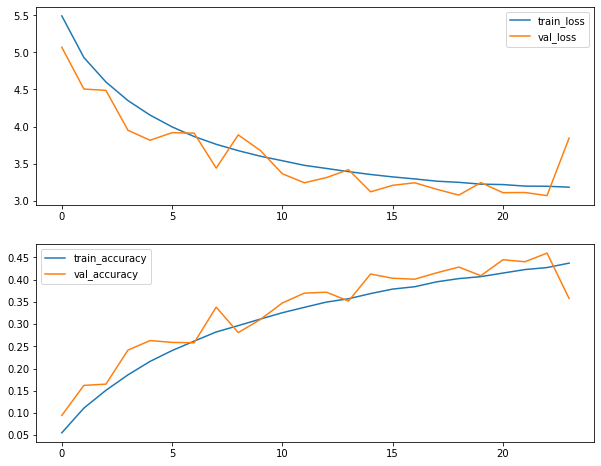

In [14]:
#Plot the loss and accuracy
import matplotlib.pyplot as plt
(fig, ax) = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(history.history["loss"], label="train_loss")
ax[0].plot(history.history["val_loss"], label="val_loss")
ax[0].legend()
ax[1].plot(history.history["accuracy"], label= "train_accuracy")
ax[1].plot(history.history["val_accuracy"], label="val_accuracy")
ax[1].legend()

### In the first round, the max validation accuracy is 45.97%

In [24]:
#Save the training history
pd.DataFrame(history.history).to_csv('./history/history_model1.csv')

### Second round with base_lr=1e-05 and max_lr=6e-05

In [4]:
# load the model
from tensorflow.keras.models import load_model
new_model = load_model("./Model/model1.hdf5")

In [8]:
# callbacks
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau
steps_per_epoch= num_train // batch_size
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=0.00001, maximal_learning_rate=0.00006,
                                          scale_fn=lambda x: 1/(2.**(x-1)), step_size=6*steps_per_epoch) #Cyclic learning rate

scheduler = tf.keras.callbacks.LearningRateScheduler(clr)
early_stopping = EarlyStopping(patience = 3, monitor='val_loss', 
                               mode='min', restore_best_weights=True)
checkpointer_2= ModelCheckpoint(filepath="./Model/model2.hdf5", verbose=1, save_best_only=True, monitor="val_accuracy")
# fit the model 
history = new_model.fit(train_generator,
                        epochs=24,
                        steps_per_epoch= num_train // batch_size,
                        validation_steps= num_validation // batch_size,
                        validation_data=validation_generator,
                        verbose=1, callbacks=[scheduler, checkpointer_2,early_stopping]
                       )

/home/ecbm4040/envTF24/lib/python3.6/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


Epoch 1/24
781/781 [==============================] - 655s 808ms/step - loss: 2.9526 - accuracy: 0.4817 - val_loss: 2.6181 - val_accuracy: 0.5544

Epoch 00001: val_accuracy improved from -inf to 0.55439, saving model to ./Model/model2.hdf5
Epoch 2/24
781/781 [==============================] - 628s 804ms/step - loss: 2.8896 - accuracy: 0.4953 - val_loss: 2.5935 - val_accuracy: 0.5609

Epoch 00002: val_accuracy improved from 0.55439 to 0.56090, saving model to ./Model/model2.hdf5
Epoch 3/24
781/781 [==============================] - 630s 806ms/step - loss: 2.8689 - accuracy: 0.4992 - val_loss: 2.5951 - val_accuracy: 0.5547

Epoch 00003: val_accuracy did not improve from 0.56090
Epoch 4/24
781/781 [==============================] - 631s 807ms/step - loss: 2.8506 - accuracy: 0.5048 - val_loss: 2.5746 - val_accuracy: 0.5624

Epoch 00004: val_accuracy improved from 0.56090 to 0.56240, saving model to ./Model/model2.hdf5
Epoch 5/24
781/781 [==============================] - 630s 806ms/step - 

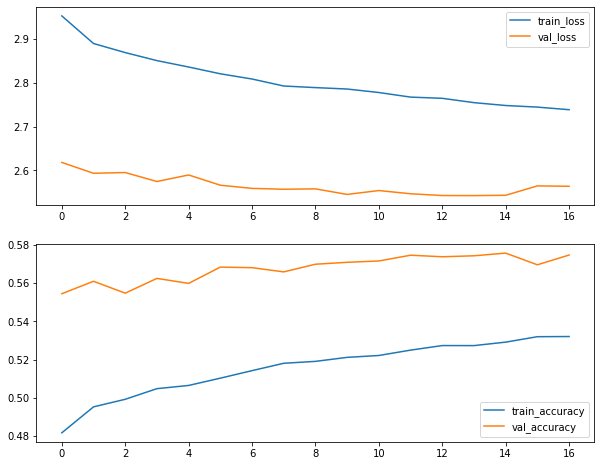

In [9]:
import matplotlib.pyplot as plt
(fig, ax) = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(history.history["loss"], label="train_loss")
ax[0].plot(history.history["val_loss"], label="val_loss")
ax[0].legend()
ax[1].plot(history.history["accuracy"], label= "train_accuracy")
ax[1].plot(history.history["val_accuracy"], label="val_accuracy")
ax[1].legend()

### The max validation accuracy is 57.56%

In [12]:
#Save the result
pd.DataFrame(history.history).to_csv('./history/history_model2.csv')

### Before further running the third round, we shall analyse the accuracy of individual classes

In [13]:
# load the model after 16 hours
from tensorflow.keras.models import load_model
extended_model = load_model("./Model/model2.hdf5")

In [14]:
#Prediction
pred=extended_model.predict(validation_generator, steps= np.ceil(num_validation/batch_size), verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)

79/79 [==============================] - 21s 272ms/step


In [15]:
# Predicted class indices of 1st 10 val images
predicted_class_indices[:10]

array([107,  40,  83,  69, 168, 161, 147,  73, 145,  39])

In [16]:
# True class indices of 1st 10 val images
validation_generator.classes[:10]

[107, 139, 140, 69, 69, 161, 147, 73, 145, 39]

In [17]:
# Predicted classes from their indices
labels = (validation_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
predictions[:10]

['n03444034',
 'n02231487',
 'n02948072',
 'n02808440',
 'n04507155',
 'n04399382',
 'n04179913',
 'n02823428',
 'n04146614',
 'n02226429']

In [18]:
# Validation class names from words.txt
import os
class_to_name = dict()
file = open('tiny-imagenet-200/words.txt','r')
data= file.readlines()
for line in data:
  words = line.strip('\n').split('\t')
  class_to_name[words[0]] = words[1].split(',')[0]
file.close()

In [19]:
# Asserting Validation Class names from words.txt
validation_class_names={}
for _class in validation_generator.class_indices.keys():
  validation_class_names.update({_class : class_to_name[_class]})

In [20]:
# Classification Report of val classes
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(validation_generator.classes, predicted_class_indices,
                            #target_names=validation_generator.class_indices.keys(),
                            target_names=validation_class_names.values(),
                            digits=4))

                          precision    recall  f1-score   support

                goldfish     0.6923    0.9000    0.7826        50
European fire salamander     0.8039    0.8200    0.8119        50
                bullfrog     0.5745    0.5400    0.5567        50
             tailed frog     0.5472    0.5800    0.5631        50
      American alligator     0.5000    0.5600    0.5283        50
         boa constrictor     0.5000    0.3400    0.4048        50
               trilobite     0.6522    0.9000    0.7563        50
                scorpion     0.6765    0.4600    0.5476        50
             black widow     0.7170    0.7600    0.7379        50
               tarantula     0.5849    0.6200    0.6019        50
               centipede     0.6444    0.5800    0.6105        50
                   goose     0.5303    0.7000    0.6034        50
                   koala     0.7551    0.7400    0.7475        50
               jellyfish     0.7069    0.8200    0.7593        50
         

### We found significant difference in precision among groups.

### We keep training the model with base_lr=1e-5 and max_lr=6e-5, and step_size in no. of epochs = 4.

In [32]:
# Callbacks
steps_per_epoch= num_train // batch_size
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=0.00001, maximal_learning_rate=0.00006,
                                          scale_fn=lambda x: 1/(2.**(x-1)), step_size=4 * steps_per_epoch) #Cyclic learning rate
scheduler = tf.keras.callbacks.LearningRateScheduler(clr)
early_stopping = EarlyStopping(patience = 5, monitor='val_loss', 
                               mode='min', restore_best_weights=True)
checkpointer_3= ModelCheckpoint(filepath="./Model/model3.hdf5", verbose=1, save_best_only=True, monitor="val_accuracy")
# fit the model
history2 = extended_model.fit(train_generator,
                             epochs=epochs,
                             steps_per_epoch= np.ceil(num_train/batch_size),
                             validation_steps= np.ceil(num_validation/batch_size),
                             validation_data=validation_generator,
                             verbose=1, callbacks=[scheduler, early_stopping,checkpointer_3],
                             )

/home/ecbm4040/envTF24/lib/python3.6/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


Epoch 1/24
782/782 [==============================] - 633s 806ms/step - loss: 2.7381 - accuracy: 0.5341 - val_loss: 2.5514 - val_accuracy: 0.5748

Epoch 00001: val_accuracy improved from -inf to 0.57480, saving model to ./Model/model3.hdf5
Epoch 2/24
782/782 [==============================] - 630s 806ms/step - loss: 2.7392 - accuracy: 0.5316 - val_loss: 2.5464 - val_accuracy: 0.5753

Epoch 00002: val_accuracy improved from 0.57480 to 0.57530, saving model to ./Model/model3.hdf5
Epoch 3/24
782/782 [==============================] - 630s 805ms/step - loss: 2.7294 - accuracy: 0.5357 - val_loss: 2.5355 - val_accuracy: 0.5772

Epoch 00003: val_accuracy improved from 0.57530 to 0.57720, saving model to ./Model/model3.hdf5
Epoch 4/24
782/782 [==============================] - 631s 806ms/step - loss: 2.7204 - accuracy: 0.5383 - val_loss: 2.5451 - val_accuracy: 0.5774

Epoch 00004: val_accuracy improved from 0.57720 to 0.57740, saving model to ./Model/model3.hdf5
Epoch 5/24
782/782 [===========

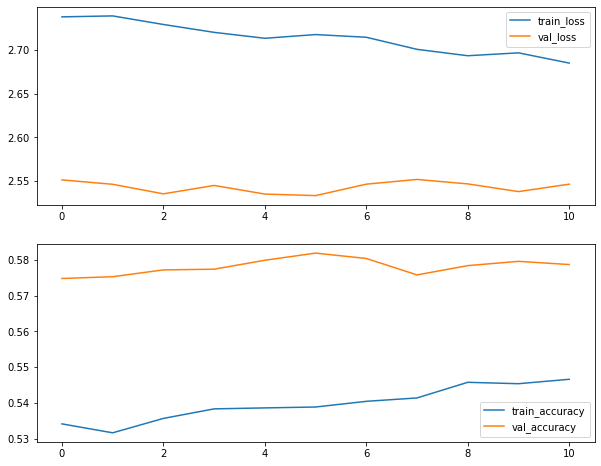

In [33]:
import matplotlib.pyplot as plt
(fig, ax) = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(history2.history["loss"], label="train_loss")
ax[0].plot(history2.history["val_loss"], label="val_loss")
ax[0].legend()
ax[1].plot(history2.history["accuracy"], label= "train_accuracy")
ax[1].plot(history2.history["val_accuracy"], label="val_accuracy")
ax[1].legend()

### The training early stopped in the 11th epoch and  max validation accuracy is 58.20%.

In [34]:
#Save the results
pd.DataFrame(history2.history).to_csv('./history/history_model3.csv')

### The fourth round with base_lr=1e-6 and max_lr=6e-6.
#### There is only 12 epochs

In [37]:
# load the model
#from keras.models import load_model
extended_model = load_model("./Model/model3.hdf5")

In [44]:
# Callbacks
steps_per_epoch= num_train // batch_size
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=0.000001, maximal_learning_rate=0.000006,
                                          scale_fn=lambda x: 1/(2.**(x-1)), step_size=2 * steps_per_epoch) #Cyclic learning rate
scheduler = tf.keras.callbacks.LearningRateScheduler(clr)
early_stopping = EarlyStopping(patience = 5, monitor='val_loss', 
                               mode='min', restore_best_weights=True)



checkpointer_4 = ModelCheckpoint(filepath="./Model/model4.hdf5", verbose=1, save_best_only=True, monitor="val_accuracy")
# fit the model
history4=extended_model.fit_generator(train_generator,
                             epochs=12,
                             steps_per_epoch= np.ceil(num_train/batch_size),
                             validation_steps= np.ceil(num_validation/batch_size),
                             validation_data=validation_generator,
                             verbose=1, callbacks=[scheduler, early_stopping, checkpointer_4]
                             )

Epoch 1/12
782/782 [==============================] - 633s 807ms/step - loss: 2.6833 - accuracy: 0.5479 - val_loss: 2.5066 - val_accuracy: 0.5863

Epoch 00001: val_accuracy improved from -inf to 0.58630, saving model to ./Model/model4.hdf5
Epoch 2/12
782/782 [==============================] - 631s 806ms/step - loss: 2.6801 - accuracy: 0.5485 - val_loss: 2.5032 - val_accuracy: 0.5874

Epoch 00002: val_accuracy improved from 0.58630 to 0.58740, saving model to ./Model/model4.hdf5
Epoch 3/12
782/782 [==============================] - 631s 807ms/step - loss: 2.6663 - accuracy: 0.5506 - val_loss: 2.5015 - val_accuracy: 0.5892

Epoch 00003: val_accuracy improved from 0.58740 to 0.58920, saving model to ./Model/model4.hdf5
Epoch 4/12
782/782 [==============================] - 629s 804ms/step - loss: 2.6689 - accuracy: 0.5495 - val_loss: 2.5035 - val_accuracy: 0.5894

Epoch 00004: val_accuracy improved from 0.58920 to 0.58940, saving model to ./Model/model4.hdf5
Epoch 5/12
782/782 [===========

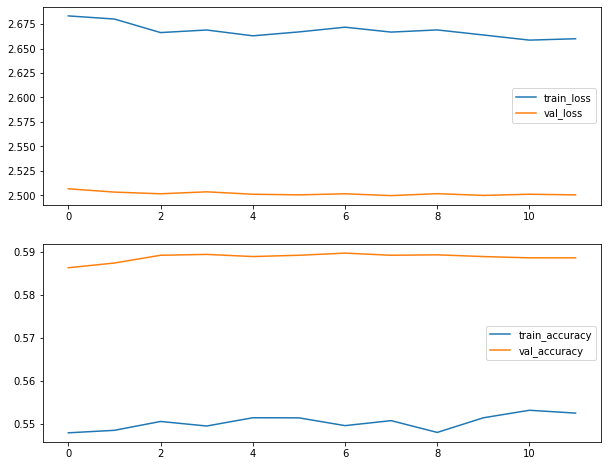

In [45]:
import matplotlib.pyplot as plt
(fig, ax) = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(history4.history["loss"], label="train_loss")
ax[0].plot(history4.history["val_loss"], label="val_loss")
ax[0].legend()
ax[1].plot(history4.history["accuracy"], label= "train_accuracy")
ax[1].plot(history4.history["val_accuracy"], label="val_accuracy")
ax[1].legend()

### The max validation accuracy is 58.97%

In [46]:
pd.DataFrame(history4.history).to_csv('./history/history_model4.csv')

### The fifth round with base_lr=1e-05 and max_lr=6e-5

In [20]:
# load the model after 28 hours
from tensorflow.keras.models import load_model
extended_model = load_model("./Model/model4.hdf5")

In [21]:
# Callbacks
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

steps_per_epoch= num_train // batch_size
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=0.00001, maximal_learning_rate=0.00006, 
                                         scale_fn=lambda x: 1/(2.**(x-1)), step_size=2*steps_per_epoch) #Cyclic learning rate

scheduler = tf.keras.callbacks.LearningRateScheduler(clr)
early_stopping = EarlyStopping(patience = 5, monitor='val_loss', 
                               mode='min', restore_best_weights=True)

checkpointer_5 = ModelCheckpoint(filepath="./Model/model5.hdf5", verbose=1, save_best_only=True, monitor="val_accuracy")
# fit the model
history5 = extended_model.fit_generator(train_generator,
                             epochs=12,
                             steps_per_epoch= np.ceil(num_train/batch_size),
                             validation_steps= np.ceil(num_validation/batch_size),
                             validation_data=validation_generator,
                             verbose=1, callbacks=[scheduler, early_stopping, checkpointer_5]
                             )

/home/ecbm4040/envTF24/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/home/ecbm4040/envTF24/lib/python3.6/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


Epoch 1/12
782/782 [==============================] - 629s 802ms/step - loss: 2.6955 - accuracy: 0.5452 - val_loss: 2.5434 - val_accuracy: 0.5789

Epoch 00001: val_accuracy improved from -inf to 0.57890, saving model to ./Model/model5.hdf5
Epoch 2/12
782/782 [==============================] - 628s 802ms/step - loss: 2.7022 - accuracy: 0.5415 - val_loss: 2.5420 - val_accuracy: 0.5818

Epoch 00002: val_accuracy improved from 0.57890 to 0.58180, saving model to ./Model/model5.hdf5
Epoch 3/12
782/782 [==============================] - 628s 802ms/step - loss: 2.6889 - accuracy: 0.5451 - val_loss: 2.5401 - val_accuracy: 0.5816

Epoch 00003: val_accuracy did not improve from 0.58180
Epoch 4/12
782/782 [==============================] - 628s 802ms/step - loss: 2.6902 - accuracy: 0.5457 - val_loss: 2.5459 - val_accuracy: 0.5811

Epoch 00004: val_accuracy did not improve from 0.58180
Epoch 5/12
782/782 [==============================] - 627s 802ms/step - loss: 2.6861 - accuracy: 0.5475 - val_los

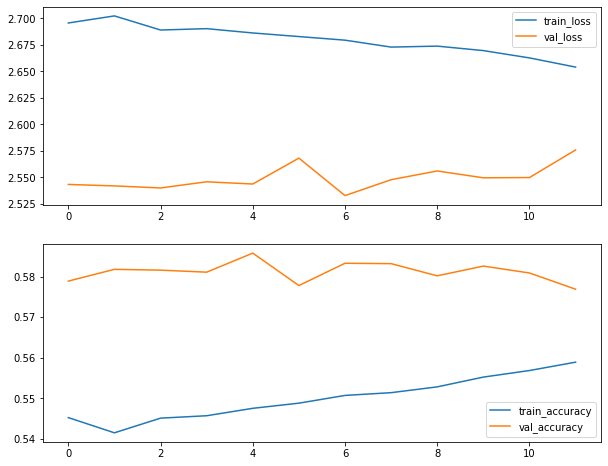

In [22]:
import matplotlib.pyplot as plt
(fig, ax) = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(history5.history["loss"], label="train_loss")
ax[0].plot(history5.history["val_loss"], label="val_loss")
ax[0].legend()
ax[1].plot(history5.history["accuracy"], label= "train_accuracy")
ax[1].plot(history5.history["val_accuracy"], label="val_accuracy")
ax[1].legend()

### The max validation accuracy is 58.58%.

In [23]:
pd.DataFrame(history5.history).to_csv('./history/history_model5.csv')

### The sixth round with base_lr=1e-07 and max_lr=6e-07

In [9]:
# load the model after 32 hours
from tensorflow.keras.models import load_model
extended_model = load_model("./Model/model5.hdf5")

In [10]:
# Callbacks
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

steps_per_epoch= num_train // batch_size
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=0.0000001, maximal_learning_rate=0.0000006, 
                                         scale_fn=lambda x: 1/(2.**(x-1)), step_size=2*steps_per_epoch) #Cyclic learning rate

scheduler = tf.keras.callbacks.LearningRateScheduler(clr)
early_stopping = EarlyStopping(patience = 5, monitor='val_loss', 
                               mode='min', restore_best_weights=True)


checkpointer_6 = ModelCheckpoint(filepath="./Model/model6.hdf5", verbose=1, save_best_only=True, monitor="val_accuracy")
# fit the model
history6 = extended_model.fit_generator(train_generator,
                             epochs=12,
                             steps_per_epoch= np.ceil(num_train/batch_size),
                             validation_steps= np.ceil(num_validation/batch_size),
                             validation_data=validation_generator,
                             verbose=1, callbacks=[scheduler, early_stopping, checkpointer_6]
                             )

/home/ecbm4040/envTF24/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/home/ecbm4040/envTF24/lib/python3.6/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


Epoch 1/12
782/782 [==============================] - 631s 792ms/step - loss: 2.6622 - accuracy: 0.5542 - val_loss: 2.5083 - val_accuracy: 0.5885

Epoch 00001: val_accuracy improved from -inf to 0.58850, saving model to ./Model/model6.hdf5
Epoch 2/12
782/782 [==============================] - 620s 792ms/step - loss: 2.6558 - accuracy: 0.5546 - val_loss: 2.5056 - val_accuracy: 0.5894

Epoch 00002: val_accuracy improved from 0.58850 to 0.58940, saving model to ./Model/model6.hdf5
Epoch 3/12
782/782 [==============================] - 620s 792ms/step - loss: 2.6559 - accuracy: 0.5556 - val_loss: 2.5048 - val_accuracy: 0.5890

Epoch 00003: val_accuracy did not improve from 0.58940
Epoch 4/12
782/782 [==============================] - 620s 792ms/step - loss: 2.6535 - accuracy: 0.5559 - val_loss: 2.5033 - val_accuracy: 0.5911

Epoch 00004: val_accuracy improved from 0.58940 to 0.59110, saving model to ./Model/model6.hdf5
Epoch 5/12
782/782 [==============================] - 620s 792ms/step - 

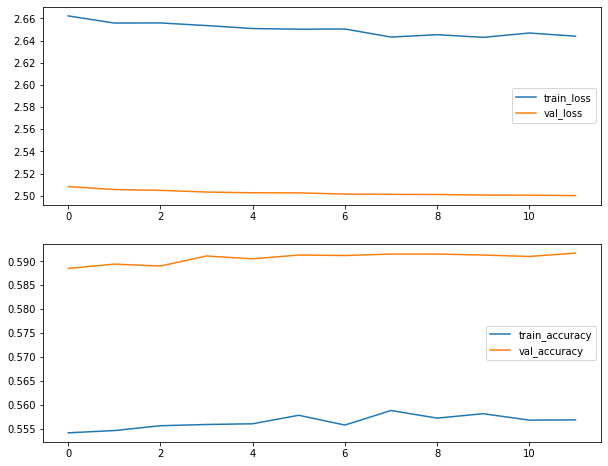

In [11]:
import matplotlib.pyplot as plt
(fig, ax) = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(history6.history["loss"], label="train_loss")
ax[0].plot(history6.history["val_loss"], label="val_loss")
ax[0].legend()
ax[1].plot(history6.history["accuracy"], label= "train_accuracy")
ax[1].plot(history6.history["val_accuracy"], label="val_accuracy")
ax[1].legend()

In [12]:
pd.DataFrame(history6.history).to_csv('./history/history_model6.csv')

# Top Validation Accuracy : 59.17%

# Results
### The training and validation loss through the whole training

Text(0.5, 1.0, 'Loss per epochs')

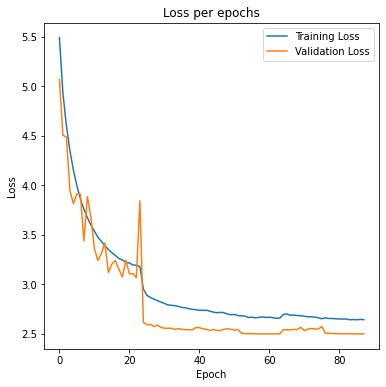

In [16]:
#Load the previous training record
import pandas as pd
history1 = pd.read_csv('./history/history_model1.csv')
history2 = pd.read_csv('./history/history_model2.csv')
history3 = pd.read_csv('./history/history_model3.csv')
history4 = pd.read_csv('./history/history_model4.csv')
history5 = pd.read_csv('./history/history_model5.csv')
history6 = pd.read_csv('./history/history_model6.csv')

history = history1.append([history2,history3, history4, history5, history6], ignore_index=True)
history = history.drop(['Unnamed: 0'], axis=1)

fig = plt.figure(num=1, figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot(history['loss'], label='Training Loss')
ax.plot(history['val_loss'], label='Validation Loss')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Loss per epochs')

### The total trend of loss for both training and validation are decreasing, there is a visible drop of validation loss in the start of second training circle.
### Also, there is a slight increase of loss in the fifth round as we increased the base_lr and max_lr.
### The training loss suffer lighter influence of changing lr than validation.

# Error Analysis

In [18]:
from tensorflow.keras.models import load_model
final_model = load_model('./Model/model6.hdf5')

In [22]:
pred=final_model.predict(validation_generator, steps= np.ceil(num_validation/batch_size), verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)

79/79 [==============================] - 19s 235ms/step


In [23]:
# Predicted classes from their indices
labels = (validation_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
predictions[:10]

['n03444034',
 'n01944390',
 'n02948072',
 'n02808440',
 'n04507155',
 'n04399382',
 'n04179913',
 'n02823428',
 'n04146614',
 'n02226429']

In [24]:
import os
class_to_name = dict()
file = open('tiny-imagenet-200/words.txt','r')
data= file.readlines()
for line in data:
  words = line.strip('\n').split('\t')
  class_to_name[words[0]] = words[1].split(',')[0]
file.close()

In [25]:
# Asserting Validation Class names from words.txt
validation_class_names={}
for _class in validation_generator.class_indices.keys():
  validation_class_names.update({_class : class_to_name[_class]})

In [39]:
# Classification Report of val classes
from sklearn.metrics import confusion_matrix, classification_report

pred_result = classification_report(validation_generator.classes, predicted_class_indices,
                            #target_names=validation_generator.class_indices.keys(),
                            target_names=validation_class_names.values(),
                            digits=4)
print(pred_result)

                          precision    recall  f1-score   support

                goldfish     0.8000    0.8800    0.8381        50
European fire salamander     0.8542    0.8200    0.8367        50
                bullfrog     0.5769    0.6000    0.5882        50
             tailed frog     0.6279    0.5400    0.5806        50
      American alligator     0.5385    0.5600    0.5490        50
         boa constrictor     0.4528    0.4800    0.4660        50
               trilobite     0.6875    0.8800    0.7719        50
                scorpion     0.6923    0.5400    0.6067        50
             black widow     0.7321    0.8200    0.7736        50
               tarantula     0.5909    0.5200    0.5532        50
               centipede     0.7045    0.6200    0.6596        50
                   goose     0.5690    0.6600    0.6111        50
                   koala     0.7222    0.7800    0.7500        50
               jellyfish     0.7885    0.8200    0.8039        50
         

### Sort the precision and find classes with top 5 errors made by the final model.

In [56]:
cf = confusion_matrix(validation_generator.classes, predicted_class_indices) 
precision = (cf / np.sum(cf, axis=0)).diagonal()
precision[:5]

array([0.8       , 0.85416667, 0.57692308, 0.62790698, 0.53846154])

In [58]:
prec = pd.DataFrame.from_dict(validation_class_names, orient='index', columns=['class'])
prec['precision'] = precision
prec.sort_values(['precision'])

,class,precision
n03970156,plunger,0.230769
n04597913,wooden spoon,0.240000
n03976657,pole,0.250000
n02909870,bucket,0.279070
n04023962,punching bag,0.306122
...,...,...
n01629819,European fire salamander,0.854167
n04118538,rugby ball,0.860000
n02279972,monarch,0.884615
n03662601,lifeboat,0.886364


### Get top-5 errors class: plunger, wooden spoon, pole, bucket and punching bag.
So, we take a look at the plunger class.

In [101]:
plunger = val_data[val_data['Class'] == 'n03970156']
plunger_datagen = ImageDataGenerator(rescale=1/255.)
plunger_generator = plunger_datagen.flow_from_dataframe(plunger,directory='./tiny-imagenet-200/val/images/', 
                                                         x_col='File', y_col='Class', 
                                                         target_size=(img_width, img_height),
                                                         class_mode='categorical', 
                                                         batch_size=batch_size, 
                                                         shuffle=False, seed=101)
plunger.head()

Found 50 validated image filenames belonging to 1 classes.


,File,Class
71,val_71.JPEG,n03970156
119,val_119.JPEG,n03970156
137,val_137.JPEG,n03970156
169,val_169.JPEG,n03970156
195,val_195.JPEG,n03970156


In [102]:
plunger_pred = final_model.predict(plunger_generator)
plunger_class = np.argmax(plunger_pred, axis=1)
plunger_predictions = [validation_class_names[labels[k]] for k in plunger_class]
plunger_predictions[:10]

['gasmask',
 'plunger',
 'space heater',
 'projectile',
 'gasmask',
 'plunger',
 "potter's wheel",
 'space heater',
 'parking meter',
 'plunger']

For the first 10 pictures, only 3 are correctly predicted.
### Visualize first 8 images.

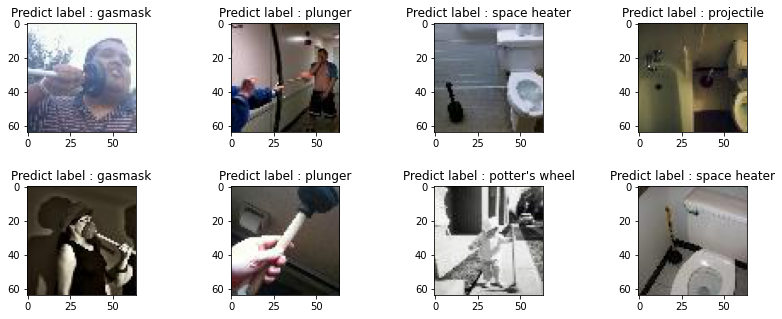

In [113]:
fig = plt.figure(figsize=(14, 5))

for i in range(8):
    sub = fig.add_subplot(2, 4, i+1)
    sub.imshow(plunger_generator[0][0][i,:,:])
    sub.set_title('Predict label : %s' %plunger_predictions[i])

fig.subplots_adjust(hspace=0.5)

#### We can see there are some misunderstanding in the intent of image.